# Credit Card Fraud Detection
This is an extension of the Credit Card Fraud Detection mini project in my repo. Here I overcome the two hidden gaps (Gridsearch and Threshold tuning against the Test dataset) in the original mini-project.  


In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedKFold
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import average_precision_score

In [2]:
data = pd.read_csv(r"C:\Users\HP\Documents\DataScience\Python Scripts\Credit Card\ULB\creditcard.csv")

## A look at the data
As see in the plot below, this data is heavly imbalanced. About 99.8% of the records are negative i.e non-fradulent records. Such heavy class imbalance needs to be handled with care as usual evaluation metrics such as accuracy don't hold good. Use case specific metrics such as Recall, Precision, True-Negative-Rate etc can be used as evaluation metrics.

Given the nature of his dataset i.e highly imbalanced and huge significance associated with finding a fradulent transactions, I have chosen Recall (primary metric) and precision, f1-score as secondary metrics.

While building classification model, I will leverage 'class_weight' parameter in Scikit-Learn to overcame the class imbalance

In [3]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


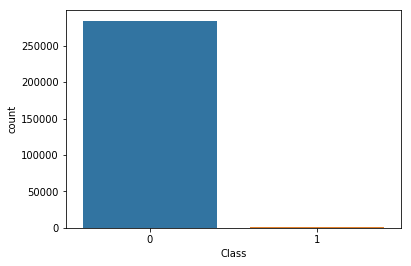

In [5]:
ax = sns.countplot(x="Class", data=data)
plt.show()

In [6]:
Imb_Q = data.loc[data.Class == 0, "Class"].count()/len(data.Class)
Imb_Q

0.99827251436937992

#### Missing values
There are no missing values in this dataset as seen below. 

In [7]:
data.isnull().any().any()

False

## Tuning the model for hyper parameters
Hyper-parameter tuning for the classifier (LinearSVC) for C and 'class weight' (since this is an heavily imbalanced dataset) is done. Towards this the Training dataset is split into CV folds (two in this case) and then custom gridsearchCV is done to find the best C & 'class weight' values.


In [18]:
colnames = list(data)

In [19]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
scaled_data = pd.DataFrame(scaled_data, columns= colnames)

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [20]:
scaled_X = scaled_data

In [21]:
scaled_y = scaled_data['Class']

In [22]:
del scaled_X['Time']
del scaled_X['Class']

In [23]:
X_s_train, X_s_test, y_s_train, y_s_test = train_test_split(scaled_X, scaled_y, test_size=0.3, random_state = 5)

In [25]:
X_s_train1, X_s_train2, y_s_train1, y_s_train2 = train_test_split(X_s_train, y_s_train, test_size=0.5, random_state = 5)

### Custom GridsearchCV - Turning for C &  Classweights - CV Block-1
Custom script (below) is run on CV Block-1 against a range of C(0.05, 0.1, 1, 10) and Class weights({0: 0.1, 1: 0.9}, {0: 0.05, 1: 0.95}, {0: 0.04, 1: 0.96}, {0: 0.03, 1: 0.97}, {0: 0.02, 1: 0.98}). Models are trained on Train-Split-1 with values in this C & Classweight grid and validated against Train-Split-2 (not on Test split)

Basis this the best params found are: C 1 Classweights {0: 0.1, 1: 0.9} that resulted in Recall of 83 and Precision of 80 and f1-score of 82. 


In [39]:
C = [0.05, 0.1, 1, 10]
ClassWeights =[{0: 0.1, 1: 0.9}, {0: 0.05, 1: 0.95}, {0: 0.04, 1: 0.96}, {0: 0.03, 1: 0.97}, {0: 0.02, 1: 0.98}]
for i in C:
    for j in ClassWeights:
        model_svc = LinearSVC(C=i, class_weight = j)
        model_svc.fit(X_s_train1, y_s_train1)
        y_s_pred2 = model_svc.predict(X_s_train2)
        print("Classification Report for C {0} Classweights {1} is: {2}".format(i, j, classification_report(y_s_pred2, y_s_train2)))    

Classification Report for C 0.05 Classweights {0: 0.1, 1: 0.9} is:               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     99563
         1.0       0.61      0.85      0.71       119

   micro avg       1.00      1.00      1.00     99682
   macro avg       0.80      0.92      0.85     99682
weighted avg       1.00      1.00      1.00     99682

Classification Report for C 0.05 Classweights {0: 0.05, 1: 0.95} is:               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     99557
         1.0       0.64      0.85      0.73       125

   micro avg       1.00      1.00      1.00     99682
   macro avg       0.82      0.92      0.86     99682
weighted avg       1.00      1.00      1.00     99682

Classification Report for C 0.05 Classweights {0: 0.04, 1: 0.96} is:               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     99554
         1.0       0.64      0.8

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Classification Report for C 10 Classweights {0: 0.1, 1: 0.9} is:               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     99520
         1.0       0.80      0.82      0.81       162

   micro avg       1.00      1.00      1.00     99682
   macro avg       0.90      0.91      0.91     99682
weighted avg       1.00      1.00      1.00     99682



C:\Users\HP\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Classification Report for C 10 Classweights {0: 0.05, 1: 0.95} is:               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     99502
         1.0       0.81      0.75      0.78       180

   micro avg       1.00      1.00      1.00     99682
   macro avg       0.91      0.87      0.89     99682
weighted avg       1.00      1.00      1.00     99682



C:\Users\HP\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Classification Report for C 10 Classweights {0: 0.04, 1: 0.96} is:               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     99499
         1.0       0.81      0.74      0.77       183

   micro avg       1.00      1.00      1.00     99682
   macro avg       0.91      0.87      0.89     99682
weighted avg       1.00      1.00      1.00     99682



C:\Users\HP\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Classification Report for C 10 Classweights {0: 0.03, 1: 0.97} is:               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     99494
         1.0       0.83      0.73      0.78       188

   micro avg       1.00      1.00      1.00     99682
   macro avg       0.92      0.87      0.89     99682
weighted avg       1.00      1.00      1.00     99682



C:\Users\HP\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Classification Report for C 10 Classweights {0: 0.02, 1: 0.98} is:               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     99485
         1.0       0.83      0.70      0.76       197

   micro avg       1.00      1.00      1.00     99682
   macro avg       0.92      0.85      0.88     99682
weighted avg       1.00      1.00      1.00     99682



### Custom GridsearchCV - Turning for C &  Classweights - CV Block-2
Custom script (below) is run on CV Block-2 against a range of C(0.05, 0.1, 1, 10) and Class weights({0: 0.1, 1: 0.9}, {0: 0.05, 1: 0.95}, {0: 0.04, 1: 0.96}, {0: 0.03, 1: 0.97}, {0: 0.02, 1: 0.98}). Models are trained on Train-Split-2 with values in this C & Classweight grid and validated against Train-Split-1 (not on Test split)

Basis this the best params found are: C 1 Classweights {0: 0.1, 1: 0.9} that resulted in Recall of 87 and Precision of 76 and f1-score of 81. 

In [40]:
C = [0.05, 0.1, 1, 10]
ClassWeights =[{0: 0.1, 1: 0.9}, {0: 0.05, 1: 0.95}, {0: 0.04, 1: 0.96}, {0: 0.03, 1: 0.97}, {0: 0.02, 1: 0.98}]
for i in C:
    for j in ClassWeights:
        model_svc = LinearSVC(C=i, class_weight = j)
        model_svc.fit(X_s_train2, y_s_train2)
        y_s_pred1 = model_svc.predict(X_s_train1)
        print("Classification Report for C {0} Classweights {1} is: {2}".format(i, j, classification_report(y_s_pred1, y_s_train1)))    

Classification Report for C 0.05 Classweights {0: 0.1, 1: 0.9} is:               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     99572
         1.0       0.54      0.87      0.67       110

   micro avg       1.00      1.00      1.00     99682
   macro avg       0.77      0.94      0.83     99682
weighted avg       1.00      1.00      1.00     99682

Classification Report for C 0.05 Classweights {0: 0.05, 1: 0.95} is:               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     99567
         1.0       0.57      0.88      0.69       115

   micro avg       1.00      1.00      1.00     99682
   macro avg       0.78      0.94      0.84     99682
weighted avg       1.00      1.00      1.00     99682

Classification Report for C 0.05 Classweights {0: 0.04, 1: 0.96} is:               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     99565
         1.0       0.58      0.8

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Classification Report for C 10 Classweights {0: 0.1, 1: 0.9} is:               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     99522
         1.0       0.78      0.87      0.82       160

   micro avg       1.00      1.00      1.00     99682
   macro avg       0.89      0.93      0.91     99682
weighted avg       1.00      1.00      1.00     99682



C:\Users\HP\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Classification Report for C 10 Classweights {0: 0.05, 1: 0.95} is:               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     99499
         1.0       0.81      0.79      0.80       183

   micro avg       1.00      1.00      1.00     99682
   macro avg       0.90      0.89      0.90     99682
weighted avg       1.00      1.00      1.00     99682



C:\Users\HP\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Classification Report for C 10 Classweights {0: 0.04, 1: 0.96} is:               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     99496
         1.0       0.81      0.78      0.80       186

   micro avg       1.00      1.00      1.00     99682
   macro avg       0.91      0.89      0.90     99682
weighted avg       1.00      1.00      1.00     99682



C:\Users\HP\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Classification Report for C 10 Classweights {0: 0.03, 1: 0.97} is:               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     99488
         1.0       0.82      0.75      0.78       194

   micro avg       1.00      1.00      1.00     99682
   macro avg       0.91      0.88      0.89     99682
weighted avg       1.00      1.00      1.00     99682



C:\Users\HP\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Classification Report for C 10 Classweights {0: 0.02, 1: 0.98} is:               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     99467
         1.0       0.84      0.70      0.76       215

   micro avg       1.00      1.00      1.00     99682
   macro avg       0.92      0.85      0.88     99682
weighted avg       1.00      1.00      1.00     99682



## Threshold Tuning 
#### Custom search for threshold using the CV blocks.
Best C and Classweight parameters found using above custom validation is used for the model. Further the model is cross validated for a range of Thresholds (i.e Decision function in this SVC case) is done. Interestingly the best thresholds found for each of the CV blocks are same i.e 'zero', but this is just a coincidence. 

### Custom search for best threshold for CV block-1

In [41]:
model_svc = LinearSVC(C=1, class_weight = {0: 0.1, 1: 0.9})
model_svc.fit(X_s_train1, y_s_train1)
y_scores = model_svc.decision_function(X_s_train2)
y_adj_pred = (y_scores >= 0).astype('int')

In [42]:
thresholds = [-1, -0.5, 0, 0.5, 1]
for threshold in thresholds:
    y_adj_pred = (y_scores >= threshold).astype('int')
    print("Classification Report for Threshold {0} is: {1}".format(threshold, classification_report(y_adj_pred, y_s_train2)))

Classification Report for Threshold -1 is:               precision    recall  f1-score   support

           0       0.87      1.00      0.93     86806
           1       0.95      0.01      0.02     12876

   micro avg       0.87      0.87      0.87     99682
   macro avg       0.91      0.51      0.48     99682
weighted avg       0.88      0.87      0.81     99682

Classification Report for Threshold -0.5 is:               precision    recall  f1-score   support

           0       1.00      1.00      1.00     99490
           1       0.83      0.72      0.77       192

   micro avg       1.00      1.00      1.00     99682
   macro avg       0.92      0.86      0.89     99682
weighted avg       1.00      1.00      1.00     99682

Classification Report for Threshold 0 is:               precision    recall  f1-score   support

           0       1.00      1.00      1.00     99522
           1       0.80      0.83      0.82       160

   micro avg       1.00      1.00      1.00     9968

### Custom search for finding best threshold for CV Block-2
The above aproach for CV block-1 is run CV block-2. Interesting Decision Function of '0' (which is also the default) is found to be the best for this block as well. 

In [43]:
model_svc = LinearSVC(C=1, class_weight = {0: 0.1, 1: 0.9})
model_svc.fit(X_s_train2, y_s_train2)
y_scores = model_svc.decision_function(X_s_train1)
y_adj_pred = (y_scores >= 0).astype('int')

In [44]:
thresholds = [-1, -0.5, 0, 0.5, 1]
for threshold in thresholds:
    y_adj_pred = (y_scores >= threshold).astype('int')
    print("Classification Report for Threshold {0} is: {1}".format(threshold, classification_report(y_adj_pred, y_s_train1)))

Classification Report for Threshold -1 is:               precision    recall  f1-score   support

           0       0.90      1.00      0.94     89116
           1       0.96      0.02      0.03     10566

   micro avg       0.90      0.90      0.90     99682
   macro avg       0.93      0.51      0.49     99682
weighted avg       0.90      0.90      0.85     99682

Classification Report for Threshold -0.5 is:               precision    recall  f1-score   support

           0       1.00      1.00      1.00     99489
           1       0.83      0.76      0.79       193

   micro avg       1.00      1.00      1.00     99682
   macro avg       0.91      0.88      0.90     99682
weighted avg       1.00      1.00      1.00     99682

Classification Report for Threshold 0 is:               precision    recall  f1-score   support

           0       1.00      1.00      1.00     99526
           1       0.76      0.87      0.81       156

   micro avg       1.00      1.00      1.00     9968

### Finding classification report for the Test data

In [47]:
model_svc = LinearSVC(C=1, class_weight = {0: 0.1, 1: 0.9})
model_svc.fit(X_s_train, y_s_train)
y_s_pred1 = model_svc.predict(X_s_test)
print("Classification Report for best params is {}".format(classification_report(y_s_pred1, y_s_test)))    

Classification Report for best params is               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     85316
         1.0       0.78      0.91      0.84       127

   micro avg       1.00      1.00      1.00     85443
   macro avg       0.89      0.95      0.92     85443
weighted avg       1.00      1.00      1.00     85443

